CHIRPS `DIÁRIO`
1. Site: https://catalog.data.gov/dataset/chirps-version-2-0-precipitation-global-0-05a-daily-1981-present-lon0360
2. url: https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalDailyP05_Lon0360

# **Importa bibliotecas**

In [1]:
import xarray as xr
import time
import proplot as pplt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# **Cálculos**

In [2]:
%%time
#========================================================================#
#               Definição da região e período dos dados 
#========================================================================#
# Utiliza um ponto central e soma 20 km para cada lado, formando um quadrado.
lat_central, lon_central, ds_km = -15.9, -41.90, 20 # =20 km
ds_graus = ds_km/100.0

lat_min = lat_central - ds_graus
lat_max = lat_central + ds_graus
lon_min = lon_central - ds_graus
lon_max = lon_central + ds_graus

# período dos dados
ano_min, mes_min, dia_min = '1981', '01', '01' 
ano_max, mes_max, dia_max = '2022', '12', '31'
time_min, time_max = f'{ano_min}-{mes_min}-{dia_min}', f'{ano_max}-{mes_max}-{dia_max}'

#========================================================================#
#                               CHIRPS
#========================================================================#
# leitudo do dado
chirps = xr.open_dataset('https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalDailyP05_Lon0360') 

# tranforma longitudes
chirps.coords['longitude'] = ((chirps.coords['longitude'] + 180) % 360) - 180 ; chirps = chirps.sortby(chirps.longitude)

# recorta para um ponto 
#chirps_regiao = dset.sel(lat=lat_central, lon=(lon_central), method='nearest').sel(time=slice(time_min, time_max))

# recorta para um quadrado e no tempo
chirps_regiao = chirps.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max)).sel(time=slice(time_min, time_max))

# calcula a média espacial dentro da região
chirps_mean = chirps_regiao.mean(dim=['latitude', 'longitude'])

# transforma para tabela
df_chirps = chirps_mean.to_dataframe()
df_chirps

CPU times: total: 109 ms
Wall time: 30.5 s


,precip
time,
1981-01-01,31.917959
1981-01-02,15.312666
1981-01-03,0.000000
1981-01-04,0.000000
1981-01-05,0.000000
...,...
2022-12-27,0.000000
2022-12-28,0.000000
2022-12-29,0.000000


# **Agrupamento dos dados**

In [3]:
# ---------------------------------------------------------- #
#                          MENSAL
# ---------------------------------------------------------- #
# total
mensal = df_chirps.groupby(pd.Grouper(freq='1M')).sum()

# climatológica
mensal_climatologia = mensal.groupby(mensal.index.month).mean()

# ---------------------------------------------------------- #
#                          ANUAL
# ---------------------------------------------------------- #
# total
anual = df_chirps.groupby(pd.Grouper(freq='1Y')).sum()

# **Figura 1:** `DIÁRIO`

In [4]:
df_chirps.head(4)

,precip
time,
1981-01-01,31.917959
1981-01-02,15.312666
1981-01-03,0.000000
1981-01-04,0.000000


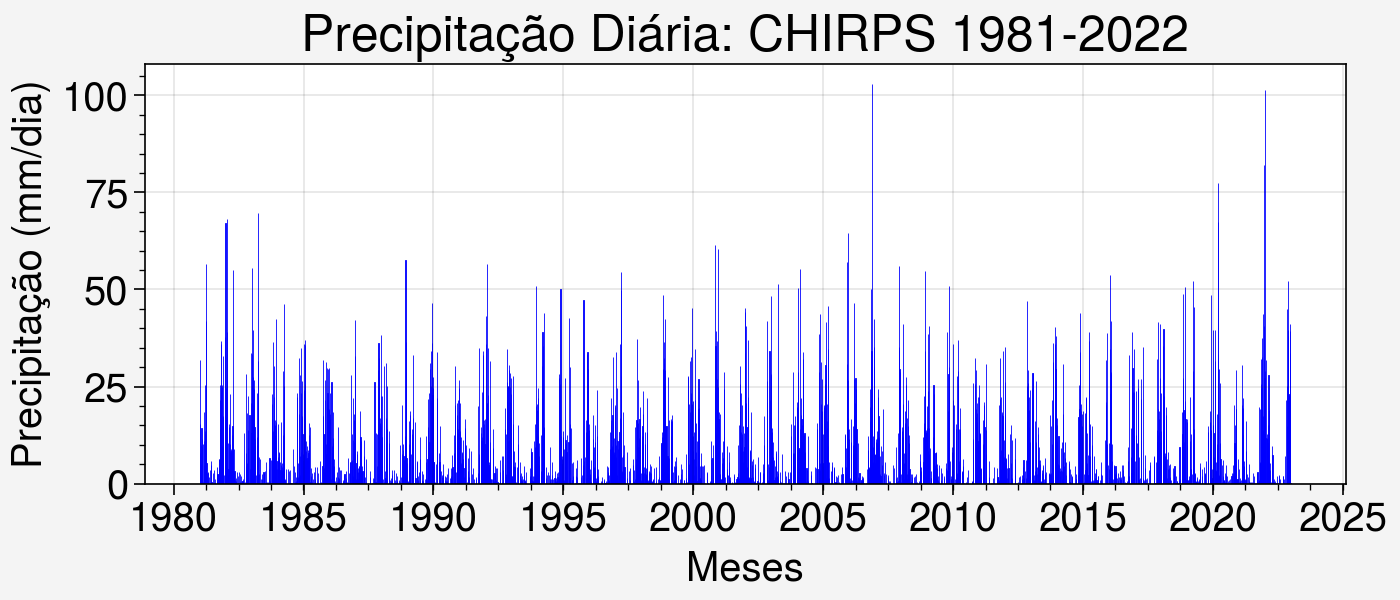

In [5]:
# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(7, 3), tight=True)

# plota gráfico de barras
ax.bar(df_chirps['precip'].index, 
       df_chirps['precip'], 
       color='blue')

# formato dos eixos
ax.format(title=f'Precipitação Diária: CHIRPS {ano_min}-{ano_max}', 
          xlabel='Meses', 
          ylabel='Precipitação (mm/dia)',
          small='20px', 
          large='25px', 
          xrotation=0)

# salva figura
fig.save(f'Fig1_diario_chirps.jpg', dpi=300)

# exibe figura na tela
pplt.show()

# **Figura 2:** `MENSAL`

**Mensal total**

In [6]:
mensal.head(4)

,precip
time,
1981-01-31,92.582764
1981-02-28,31.960760
1981-03-31,253.653748
1981-04-30,50.925102


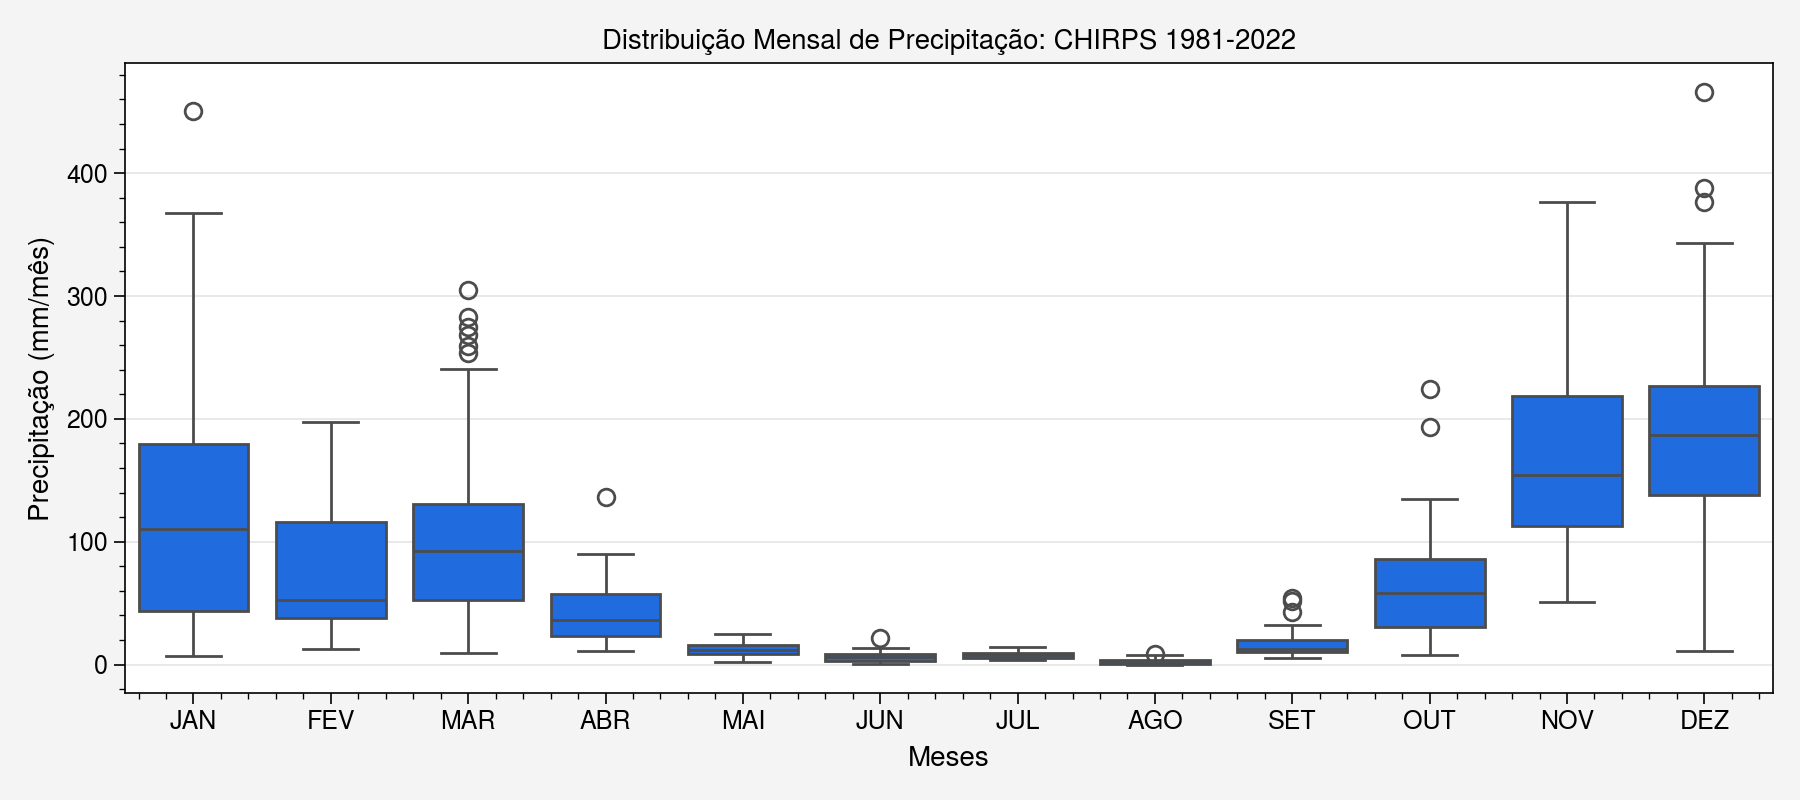

In [7]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=mensal.index.month, 
            y=mensal['precip'], 
            ax=ax, 
            color='bright blue')

ax.set_title(f'Distribuição Mensal de Precipitação: CHIRPS {ano_min}-{ano_max}')

ax.set_xlabel('Meses', fontsize=10)
ax.set_ylabel('Precipitação (mm/mês)', fontsize=10)

ax.set_xticklabels(['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'])

# salva figura
plt.savefig('Fig2a_mensal_chirps.jpg', dpi=300, bbox_inches='tight')

# exibe figura na tela
plt.tight_layout()
plt.show()

**Mensal climatológica**

In [8]:
mensal_climatologia.head(4)

,precip
time,
1,130.863678
2,75.136826
3,110.191605
4,41.676788


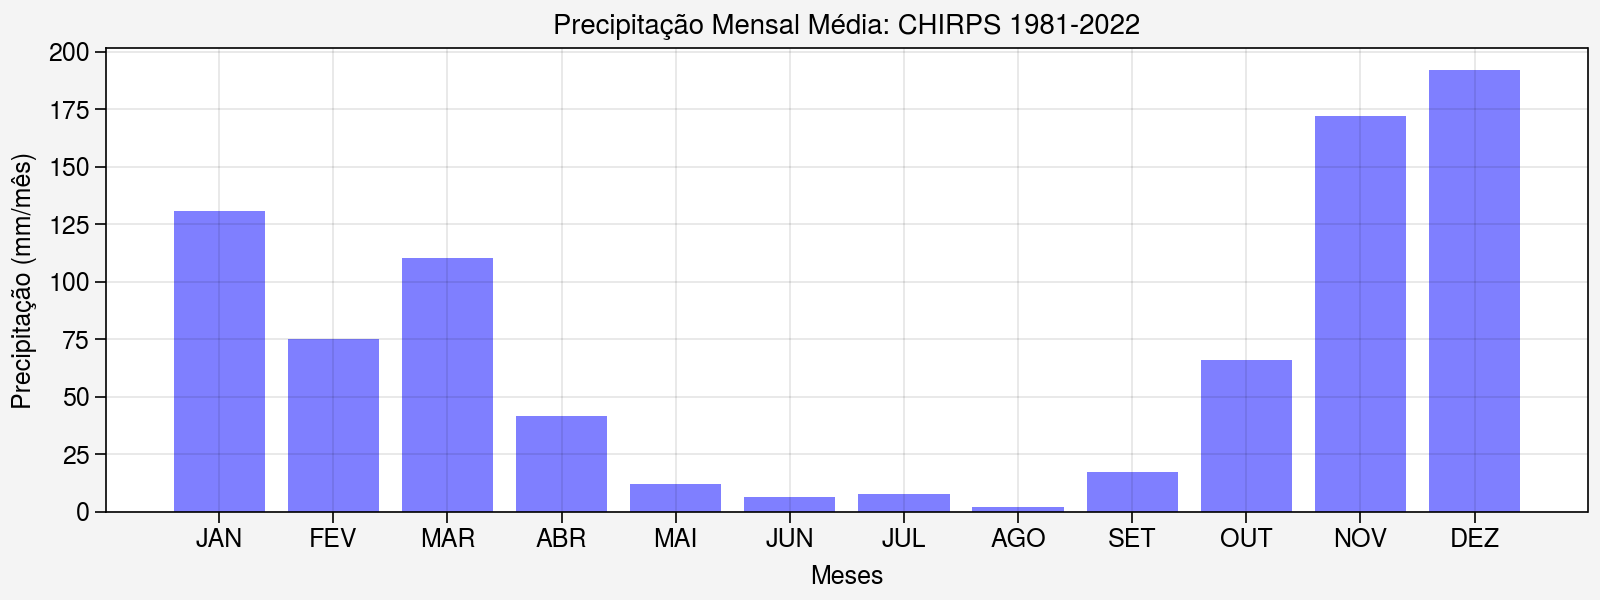

In [9]:
# cria moldura da figura
fig, ax = pplt.subplots(figsize=(8, 3), tight=True)

# precipitação
ax.bar(pplt.arange(1, 12, 1), 
       mensal_climatologia['precip'], 
       color='blue',
       alpha=0.5)

# formatações
ax.format(title=f'Precipitação Mensal Média: CHIRPS {ano_min}-{ano_max}',
          xlabel='Meses', ylabel='Precipitação (mm/mês)',
          xticklabels=['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN',
                       'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
          xticks=pplt.arange(1, 12, 1),
          xtickminor=False, ytickminor=False)

# salva figura
fig.save('Fig2b_mensal_climatologia_chirps.jpg', dpi=300)

# exibe figura na tela
pplt.show()

# **Figura 3:** `POR ANO`

In [10]:
anual.head(4)

,precip
time,
1981-12-31,1041.464844
1982-12-31,823.858337
1983-12-31,1231.737549
1984-12-31,654.931274


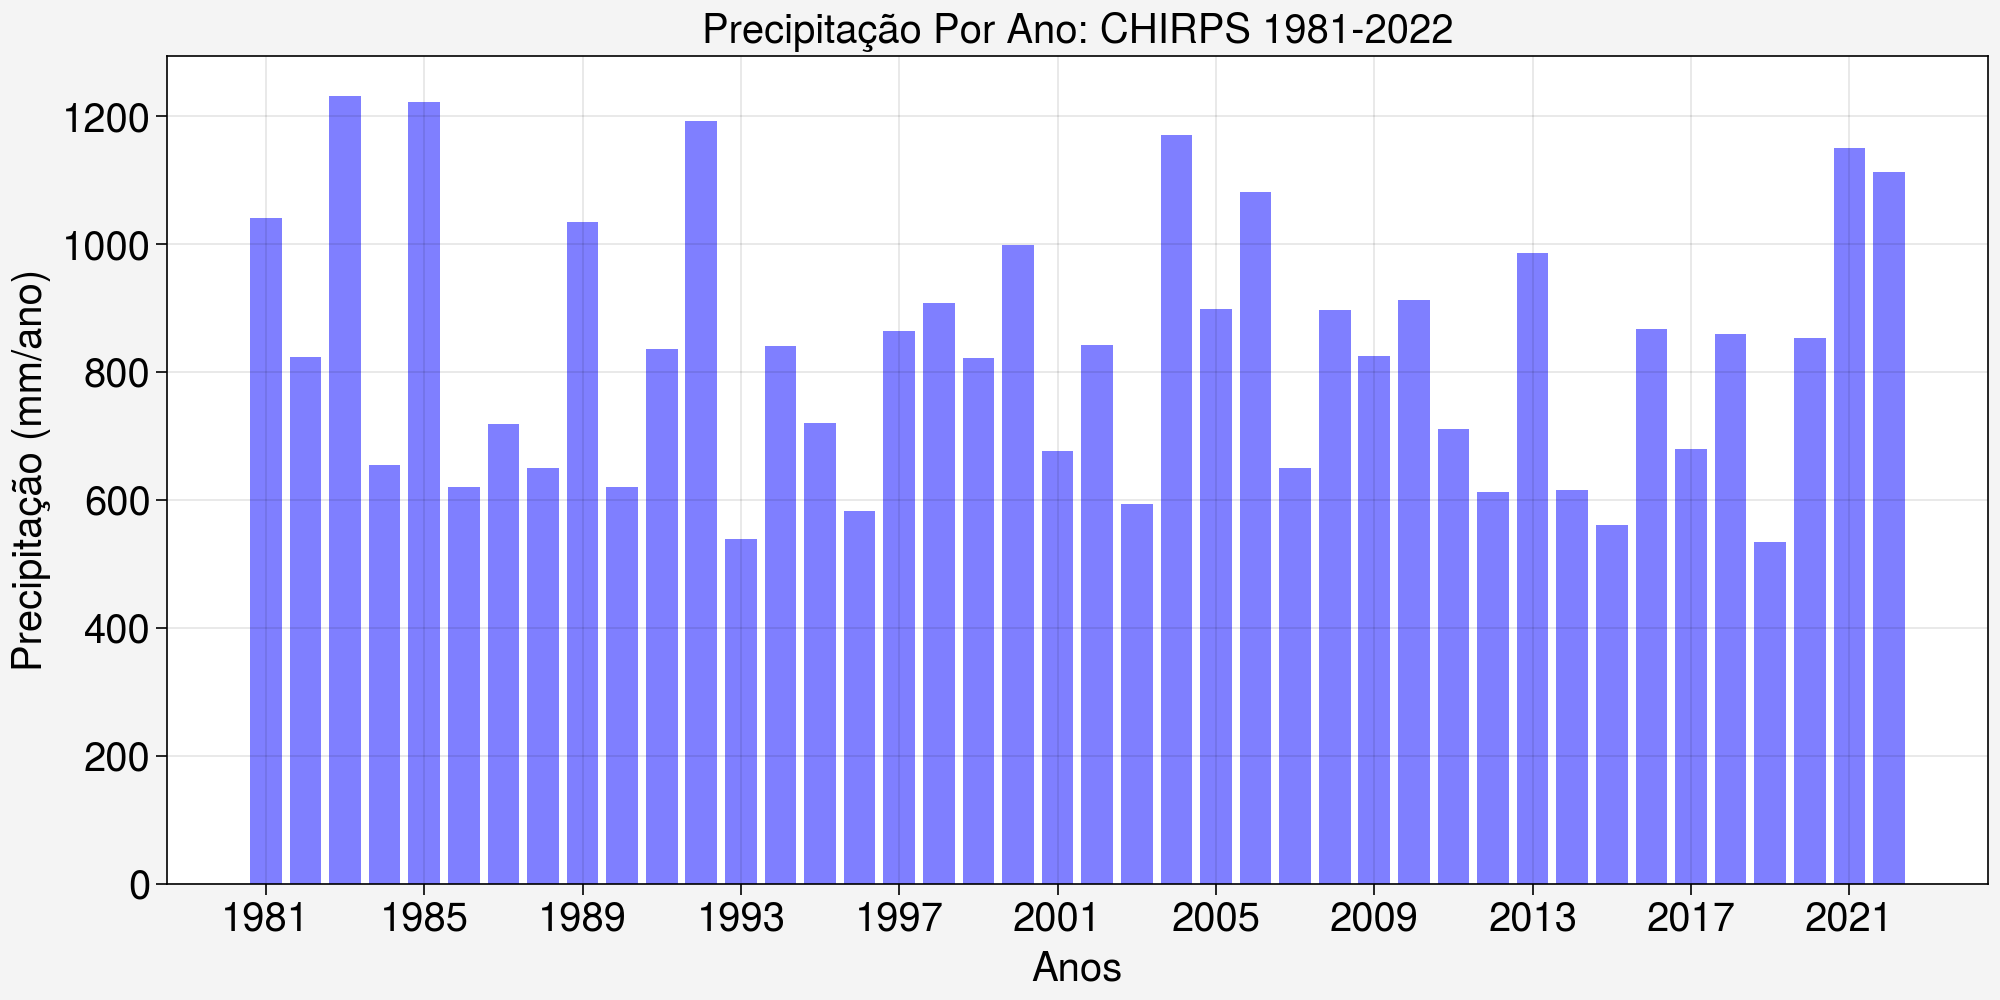

In [12]:
# cria moldura da figura
fig, ax = pplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(anual.index.year,
       anual['precip'].values,
       color='blue', 
       alpha=0.5)

# formatação do eixo
ax.format(title=f'Precipitação Por Ano: CHIRPS {ano_min}-{ano_max}', 
          xlabel='Anos', 
          ylabel='Precipitação (mm/ano)',
          small='20px', 
          large='20px',
          xtickminor=False, 
          ytickminor=False,
          xticks=pplt.arange(int(ano_min), int(ano_max), 4))

# salva figura
fig.save('Fig3_anual_chirps.jpg', dpi=300)

# exibe figura na tela
pplt.show()